# Fabulous and powerful SunPy coordinates
Albert Y. Shih (`sunpy.coordinates` lead maintainer)

This notebook shows off what the SunPy coordinates framework can enable.  There are brief explanations in this notebook, but you can take a look at the following gallery examples that use the same functionality:

* [Getting the location of the planets](https://docs.sunpy.org/en/stable/generated/gallery/units_and_coordinates/planet_locations.html#sphx-glr-generated-gallery-units-and-coordinates-planet-locations-py)
* [Reprojecting images to different observers](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html)
* [Differentially rotating a coordinate](https://docs.sunpy.org/en/stable/generated/gallery/differential_rotation/differentially_rotated_coordinate.html)
* [Differentially rotating a map](https://docs.sunpy.org/en/stable/generated/gallery/differential_rotation/reprojected_map.html#sphx-glr-generated-gallery-differential-rotation-reprojected-map-py)
* [Overlaying differentially rotated gridlines](https://docs.sunpy.org/en/stable/generated/gallery/differential_rotation/differentially_rotated_gridlines.html)

In [1]:
import numpy as np
from matplotlib.figure import Figure
from reproject import reproject_interp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import (
    HeliographicStonyhurst,
    Helioprojective,
    RotatedSunFrame,
    get_horizons_coord,
    transform_with_sun_center
)
from sunpy.net import Fido, attrs as a
from sunpy.time import parse_time

## Plotting spacecraft locations during a PSP perihelion

In [2]:
# Define two weeks on either side of a PSP perihelion
perihelion_time = parse_time('2020-06-07 08:23')
perihelion_sequence = perihelion_time + np.arange(-14, 15)*u.day

In [3]:
# Obtain the spacecraft locations through JPL HORIZONS and transform to Heliocentric Inertial (HCI)
psp_coord = get_horizons_coord('Parker Solar Probe', perihelion_sequence).heliocentricinertial
sdo_coord = get_horizons_coord('SDO', perihelion_sequence).heliocentricinertial

INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


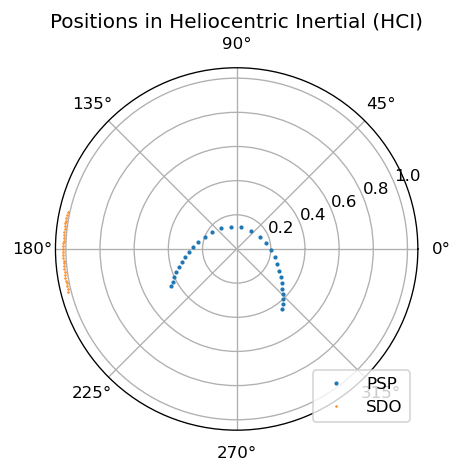

In [4]:
# Plot the spacecraft locations in HCI
fig = Figure(dpi=120)
ax = fig.add_subplot(projection='polar')

ax.plot(psp_coord.lon.to('rad'), psp_coord.distance,
        '.', markersize=3, label='PSP')
ax.plot(sdo_coord.lon.to('rad'), sdo_coord.distance,
        '.', markersize=1, label='SDO')

ax.legend(loc='lower right')
ax.set_title('Positions in Heliocentric Inertial (HCI)')
fig

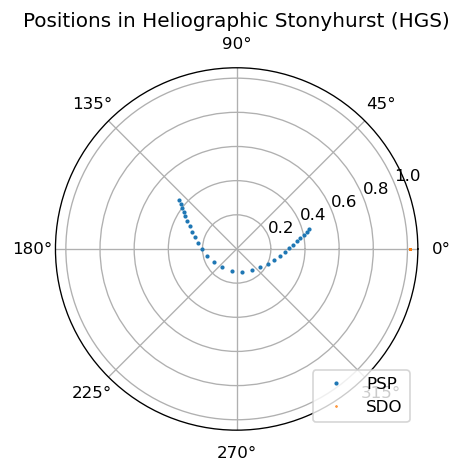

In [5]:
# Plot the spacecraft locations in Heliographic Stonyhurst (HGS)
fig = Figure(dpi=120)
ax = fig.add_subplot(projection='polar')

# Transform to HGS
psp_coord_hgs = psp_coord.heliographic_stonyhurst
sdo_coord_hgs = sdo_coord.heliographic_stonyhurst

ax.plot(psp_coord_hgs.lon.to('rad'), psp_coord_hgs.radius,
        '.', markersize=3, label='PSP')
ax.plot(sdo_coord_hgs.lon.to('rad'), sdo_coord_hgs.radius,
        '.', markersize=1, label='SDO')

ax.legend(loc='lower right')
ax.set_title('Positions in Heliographic Stonyhurst (HGS)')
fig

## Reprojecting AIA images to the view from PSP

In [6]:
# Retrieve the AIA images for a time cadence of 2 days starting with perihelion
results = Fido.search(a.Instrument.aia,
                      a.Physobs.intensity,
                      a.Wavelength(171*u.angstrom),
                      a.Time(perihelion_sequence[14], perihelion_sequence[14] + 11*u.s)
                      | a.Time(perihelion_sequence[16], perihelion_sequence[16] + 11*u.s)
                      | a.Time(perihelion_sequence[18], perihelion_sequence[18] + 11*u.s)
                      | a.Time(perihelion_sequence[20], perihelion_sequence[20] + 11*u.s))
files = Fido.fetch(results)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [7]:
# Create a MapSequence
original_seq = sunpy.map.Map(files, sequence=True)

# Set all of the maps to have the same minimum/maximum for the plotted pixel values
for m in original_seq:
    m.plot_settings['norm'].vmin = 0
    m.plot_settings['norm'].vmax = 3000

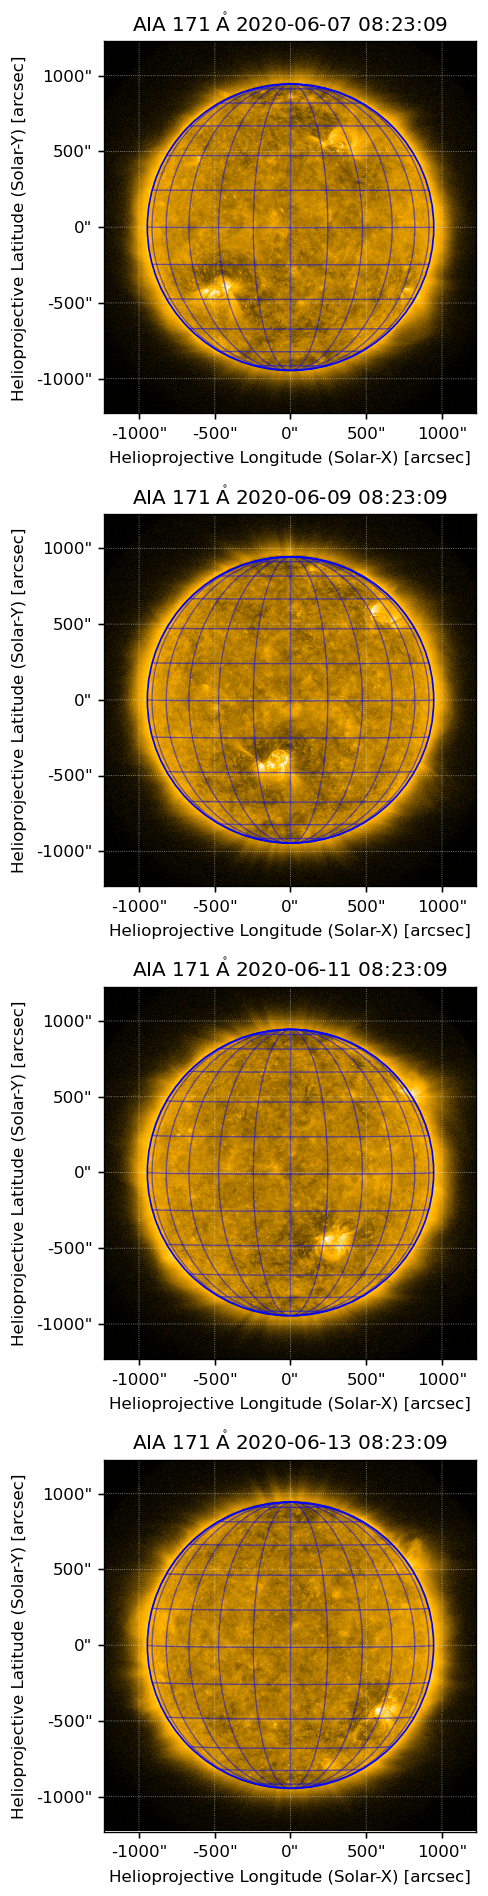

In [8]:
# Plot all of the original maps with overlaid limb and HGS grid
fig = Figure(figsize=(4, 20), dpi=120)

for i, m in enumerate(original_seq):
    ax = fig.add_subplot(len(original_seq), 1, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_limb(axes=ax, color='blue')
    m.draw_grid(axes=ax, color='blue')

fig

In [9]:
# Reproject all of the AIA maps to the view from PSP

reprojected_seq = []

for m, o in zip(original_seq, psp_coord[14:21:2]):
    # Define the reference coordinate and frame as HPC disk center as seen from PSP
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                         frame='helioprojective', obstime=o.obstime, observer=o)

    # Create a FITS WCS header for the reference coordinate and frame
    header = sunpy.map.make_fitswcs_header(
        (1000, 1000),
        ref_coord,
        scale=[16, 16]*u.arcsec/u.pix,
    )
    header['rsun_ref'] = m.meta['rsun_ref']

    # Reproject the map to the new WCS
    with transform_with_sun_center():
        output, _ = reproject_interp(m, WCS(header), (1000, 1000))
    outmap = sunpy.map.Map((output, header))
    outmap.plot_settings = m.plot_settings

    reprojected_seq.append(outmap)

reprojected_seq = sunpy.map.Map(reprojected_seq, sequence=True)

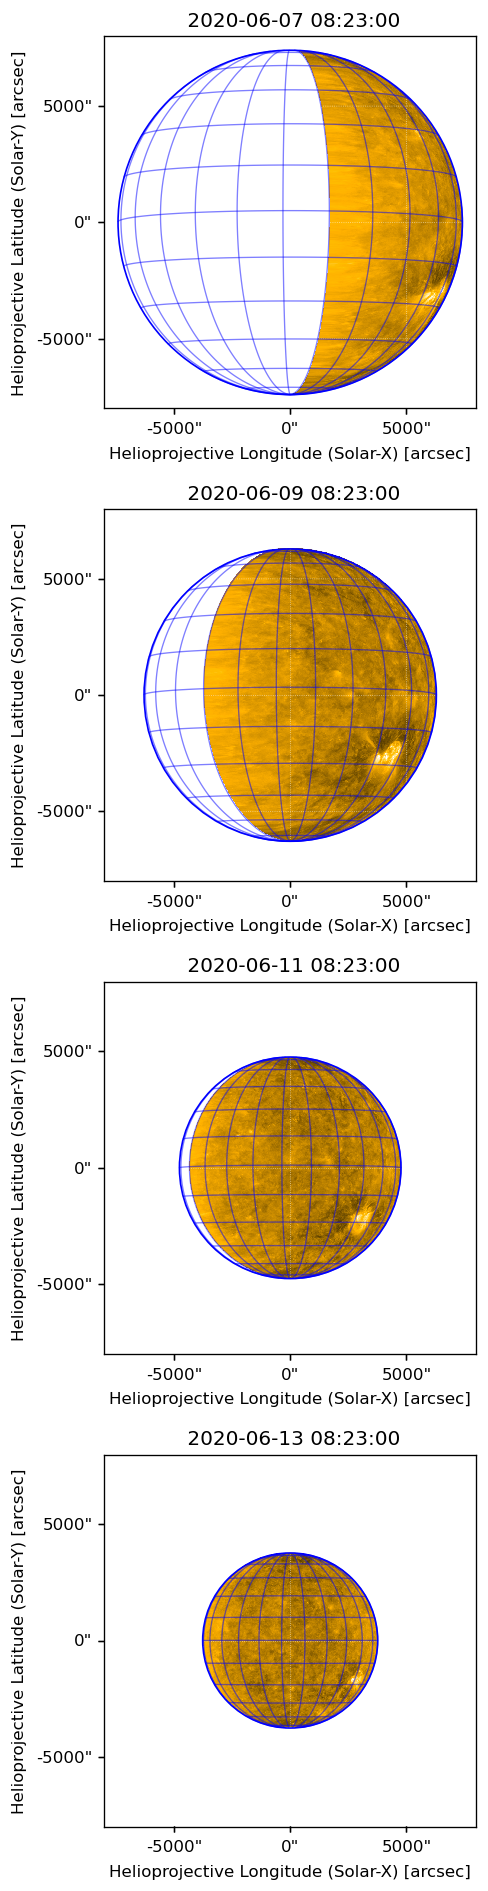

In [10]:
# Plot all of the reprojected maps with overlaid limb and HGS grid
fig = Figure(figsize=(4, 20), dpi=120)

for i, m in enumerate(reprojected_seq):
    ax = fig.add_subplot(len(reprojected_seq), 1, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_grid(axes=ax, color='blue')
    m.draw_limb(axes=ax, color='blue')

fig

## Tracking a solar feature as it rotates

In [11]:
# Define a coordinate for a bright feature on the solar disk
marker = SkyCoord(-425*u.arcsec, -400*u.arcsec, frame=original_seq[0].coordinate_frame)

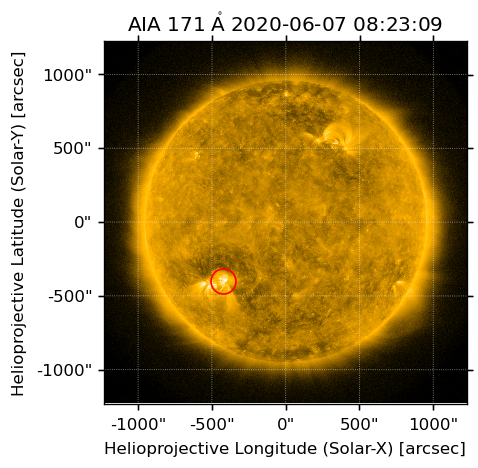

In [12]:
# Mark the coordinate on the plot
fig = Figure(dpi=120)
ax = fig.add_subplot(projection=original_seq[0])

original_seq[0].plot(axes=ax)
ax.plot_coord(marker, 'o', color='red', fillstyle='none', markersize=15)

fig

In [13]:
# Differentially rotate that coordinate to 6 days later
diffrot_marker = RotatedSunFrame(base=marker, rotated_time=original_seq[3].date)

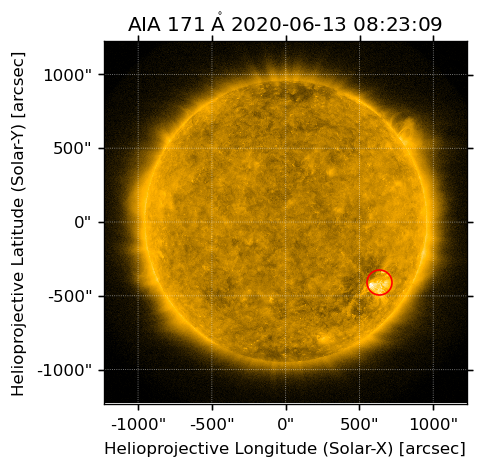

In [14]:
fig = Figure(dpi=120)
ax = fig.add_subplot(projection=original_seq[3])

original_seq[3].plot(axes=ax)
ax.plot_coord(diffrot_marker, 'o', color='red', fillstyle='none', markersize=15)

fig

## Differentially rotating a map

In [15]:
# Differentially rotate the AIA map taken at perihelion to predict what AIA will see 6 days later

ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', obstime=sdo_coord[20].obstime, observer=sdo_coord[20])
rot_frame = RotatedSunFrame(base=ref_coord, rotated_time=sdo_coord[14].obstime)

header = sunpy.map.make_fitswcs_header(
    (1024, 1024),
    ref_coord,
    scale=[2.4, 2.4]*u.arcsec/u.pix,
)
header['rsun_ref'] = m.meta['rsun_ref']

out_wcs = WCS(header)
out_wcs.coordinate_frame = rot_frame

with transform_with_sun_center():
    output, _ = reproject_interp(original_seq[0], out_wcs, (1024, 1024))

outmap = sunpy.map.Map((output, header))
outmap.plot_settings = original_seq[0].plot_settings

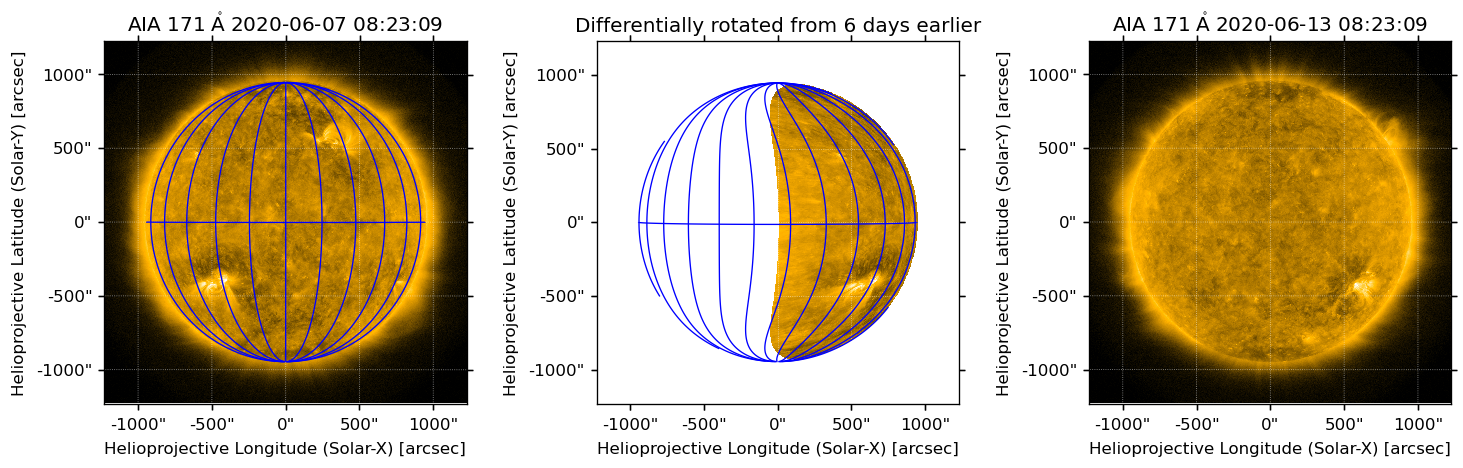

In [16]:
# Compare the differentially rotated observation with the actual AIA observation
fig = Figure(figsize=(15, 4), dpi=120)

ax = fig.add_subplot(1, 3, 1, projection=original_seq[0])
original_seq[0].plot(axes=ax)

# Overlay HGS longitude lines
overlay = ax.get_coords_overlay(HeliographicStonyhurst(obstime=original_seq[0].date, rsun=original_seq[0].rsun_meters))
overlay[0].set_ticks(spacing=15. * u.deg)
overlay[1].set_ticks(spacing=90. * u.deg)
overlay.grid(ls='-', color='blue')

ax = fig.add_subplot(1, 3, 2, projection=outmap)
outmap.plot(axes=ax, title='Differentially rotated from 6 days earlier')

# Overlay the differentially rotated grid lines
rs_hgs = RotatedSunFrame(base=HeliographicStonyhurst(obstime=original_seq[0].date, rsun=original_seq[0].rsun_meters),
                         rotated_time=outmap.date)
overlay = ax.get_coords_overlay(rs_hgs)
overlay[0].set_ticks(spacing=15. * u.deg)
overlay[1].set_ticks(spacing=90. * u.deg)
overlay.grid(ls='-', color='blue')

ax = fig.add_subplot(1, 3, 3, projection=original_seq[3])
original_seq[3].plot(axes=ax)


with transform_with_sun_center():
    display(fig)

## Nariaki's question
How do you reproject images as if they were taken at disk center?  A SunPy equivalent to https://hesperia.gsfc.nasa.gov/ssw/yohkoh/ucon/idl/metcalf/ideproject.pro ?

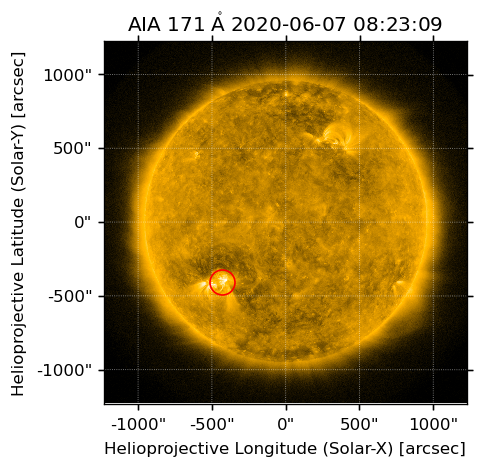

In [17]:
# Let's pick a spot on the solar surface

fig = Figure(dpi=120)
ax = fig.add_subplot(projection=original_seq[0])

original_seq[0].plot(axes=ax)
ax.plot_coord(SkyCoord(-30*u.deg, -25*u.deg,
                         frame='heliographic_stonyhurst', obstime=original_seq[0].date),
              'o', color='red', fillstyle='none', markersize=15)

fig

In [18]:
# Let's reproject to a (mock) observer directly over this point on the Sun

# Define a mock observer
mock_observer = SkyCoord(-30*u.deg, -25*u.deg, original_seq[0].dsun,
                         frame='heliographic_stonyhurst', obstime=original_seq[0].date)

# Define the reference coordinate and frame as HPC disk center as seen from a mock observer
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', obstime=original_seq[0].date, observer=mock_observer)

# Create a FITS WCS header for the reference coordinate and frame
header = sunpy.map.make_fitswcs_header(
    (1024, 1024),
    ref_coord,
    scale=[2.4, 2.4]*u.arcsec/u.pix,
)
header['rsun_ref'] = m.meta['rsun_ref']

# Reproject the map to the new WCS
with transform_with_sun_center():
    output, _ = reproject_interp(original_seq[0], WCS(header), (1024, 1024))
outmap = sunpy.map.Map((output, header))
outmap.plot_settings = m.plot_settings

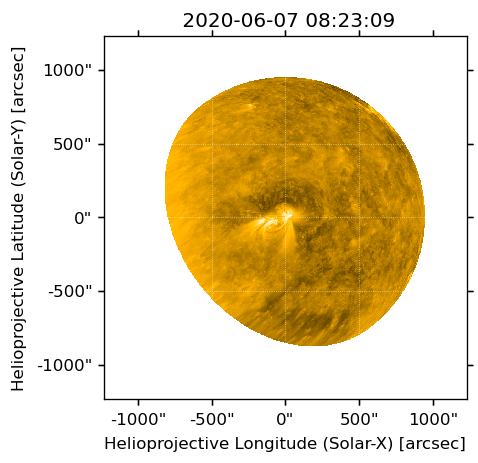

In [19]:
# Plot the reprojection

fig = Figure(dpi=120)
ax = fig.add_subplot(projection=outmap)

outmap.plot(axes=ax)

fig